[← Previous: Quick Quality Check](01_quick_qc.ipynb)

# **Cleaning & Merge**


This notebook cleans raw Reddit submissions and comments, then merges them into an analysis ready dataset. We preserve negations for sentiment analysis, extract top-level comments ranked by score, and filter out near-empty posts to ensure content quality.

**Process:**
1. Load and clean submissions (6,503 posts) and comments
2. Normalize text while preserving negations (`not`, `never`, `no`)
3. Extract top-5 comments per post (ranked by score, depth=0 only)
4. Merge into the final dataset with combined text fields
5. Apply quality filters (minimum seven tokens per post)

**Output:** `reddit_anxiety_v1.parquet` with 6,283 posts, each containing title, selftext, and top comments in `text_all` field.

---

## Table of Contents

- [1. BEFORE: quick peek at raw files](#1-before-quick-peek-at-raw-files)
- [2. Normalize & light clean](#2-normalize--light-clean)
- [3. BEFORE metrics snapshot](#3-before-metrics-snapshot)
- [4. Build `comments_concat` (top‑k by score)](#4-build-comments_concat-topk-by-score)
- [5. AFTER: merge into a single row per submission](#5-after-merge-into-a-single-row-per-submission)
- [6. Save artifacts](#6-save-artifacts)
- [7. Quick QC figures](#7-quick-qc-figures)
- [8. Parameters & summary](#8-parameters--summary)

[Next: Topic Modeling with NMF →](03_topic_modeling_byNMF.ipynb)

---

In [52]:
# remove -q to see output
%pip install -q -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [53]:
# Import required libraries
from pathlib import Path
import pandas as pd
import numpy as np
import json
import re
from itertools import islice
import matplotlib.pyplot as plt
import seaborn as sns

# Set up directory paths for data pipeline
DATA_RAW = Path("../data/raw")                                                           # Raw input data
DATA_INTERIM = Path("../data/interim"); DATA_INTERIM.mkdir(parents=True, exist_ok=True)  # Intermediate cleaned data
DATA_PROC = Path("../data/processed"); DATA_PROC.mkdir(parents=True, exist_ok=True)      # Final processed data
ARTIFACTS = Path("../artifacts/images/"); ARTIFACTS.mkdir(parents=True, exist_ok=True)   # Output figures

# Define input file paths
RAW_SUBS = DATA_RAW / "submission.jsonl"    # Reddit submissions data
RAW_COMS = DATA_RAW / "comments_topk.jsonl" # Reddit comments data

# Verify input files exist
print("Exists:", RAW_SUBS.exists(), RAW_COMS.exists())


Exists: True True


---


## **1. BEFORE: quick peek at raw files**
We sample a few lines from each JSONL to show the schema and typical values.


In [54]:
def head_jsonl(path, n=3):
    """Load the first n rows of a JSONL file into a pandas DataFrame."""
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        # Read first n lines and parse each as JSON
        for line in islice(f, n):
            rows.append(json.loads(line))
    return pd.DataFrame(rows)

# Load sample data from both JSONL files
subs_head = head_jsonl(RAW_SUBS, 5)
coms_head = head_jsonl(RAW_COMS, 5)

# Preview the data structure
display(subs_head.head(3))
display(coms_head.head(3))

# Check available columns
print("Submissions columns:", list(subs_head.columns))
print("Comments columns:", list(coms_head.columns))

,post_id,subreddit,created_utc,title,selftext,score,num_comments,upvote_ratio,over_18,removed_by_category
0,1nkes7e,Anxiety,1.758217e+09,Terrified of my symptoms,So I just got over a nasty cold but the cough ...,1,0,1.0,False,None
1,1nkes09,Anxiety,1.758217e+09,Does anyone else here have chronic tinnitus?,This crap is driving me insane.\n\nI’ve been a...,1,0,1.0,False,None
2,1njtn2a,Anxiety,1.758154e+09,I can't sleep anymore,"Hey everyone, I've been diagnosed with anxiety...",1,1,1.0,False,None


,comment_id,link_id,parent_id,body,created_utc,score,depth
0,nex9mf6,1njtn2a,1njtn2a,Hello! \n\nI would suggest some deep breathing...,1.758217e+09,1,0
1,nex51um,1nke23t,1nke23t,"Look into magnesium glycinate at night, I had ...",1.758216e+09,1,0
2,nex7wp1,1nke23t,1nke23t,"If it gives you any peace, these are all sympt...",1.758216e+09,1,0


Submissions columns: ['post_id', 'subreddit', 'created_utc', 'title', 'selftext', 'score', 'num_comments', 'upvote_ratio', 'over_18', 'removed_by_category']
Comments columns: ['comment_id', 'link_id', 'parent_id', 'body', 'created_utc', 'score', 'depth']


---


## **2. Normalize & light clean**
We lowercase, strip URLs/usernames, and normalize whitespace...but we **keep** negation words.


In [55]:
def clean_text(s: str) -> str:
    """Normalize text by removing URLs, usernames, and extra whitespace."""
    if not isinstance(s, str): return ""
    s = s.lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)    # Remove URLs
    s = re.sub(r"u/[A-Za-z0-9_-]+", " ", s)    # Remove Reddit usernames
    s = re.sub(r"\s+", " ", s).strip()         # Normalize whitespace
    return s


### **2.1 Submissions -> minimal consistent schema**
We keep the original text alongside cleaned columns for *before/after* comparison.


In [56]:
# Load submissions data from JSONL file
subs_raw = pd.read_json(RAW_SUBS, lines=True)
subs = subs_raw.rename(columns={"created_utc":"created_ts"}).copy()

# Convert data types and handle missing values
subs["post_id"] = subs["post_id"].astype(str)
subs["created_dt"] = pd.to_datetime(subs["created_ts"], unit="s", errors="coerce")
subs["title"] = subs["title"].fillna("")
subs["selftext"] = subs["selftext"].fillna("")

# Remove posts where both title and selftext are deleted/removed
dead = subs["title"].str.fullmatch(r"\[deleted\]|\[removed\]", na=False) & \
       subs["selftext"].str.fullmatch(r"\[deleted\]|\[removed\]", na=False)
before_n = len(subs)
subs = subs[~dead].copy()
after_n = len(subs)

# Apply text cleaning to title and selftext
subs["title_clean"] = subs["title"].map(clean_text)
subs["selftext_clean"] = subs["selftext"].map(clean_text)

# Show results
print(f"Submissions: {before_n} -> {after_n} after removing deleted/removed-only rows")
display(subs[["post_id","title","selftext","title_clean","selftext_clean"]].head(3))

Submissions: 6503 -> 6503 after removing deleted/removed-only rows


,post_id,title,selftext,title_clean,selftext_clean
0,1nkes7e,Terrified of my symptoms,So I just got over a nasty cold but the cough ...,terrified of my symptoms,so i just got over a nasty cold but the cough ...
1,1nkes09,Does anyone else here have chronic tinnitus?,This crap is driving me insane.\n\nI’ve been a...,does anyone else here have chronic tinnitus?,this crap is driving me insane. i’ve been avoi...
2,1njtn2a,I can't sleep anymore,"Hey everyone, I've been diagnosed with anxiety...",i can't sleep anymore,"hey everyone, i've been diagnosed with anxiety..."



### **2.2 Comments -> align to `post_id` and clean**
We restrict to **top-level** comments (`depth==0`) as concise context.


In [57]:
# Load comments data from JSONL file
coms_raw = pd.read_json(RAW_COMS, lines=True)
coms = coms_raw.rename(columns={"created_utc":"created_ts"}).copy()

# Set up IDs and handle missing values (link_id already matches submission post_id)
coms["post_id"] = coms["link_id"].astype(str)
coms["comment_id"] = coms["comment_id"].astype(str)
coms["body"] = coms["body"].fillna("")

# Remove deleted/removed comments and clean text
coms = coms[~coms["body"].str.fullmatch(r"\[deleted\]|\[removed\]", na=False)].copy()
coms["body_clean"] = coms["body"].map(clean_text)

# Show all comments
print("Comments (all):", len(coms))
display(coms[["comment_id","post_id","depth","score","body","body_clean"]].head(3))

# Filter to top-level comments only (depth == 0)
coms_top = coms.query("depth == 0").copy()
print("Top-level comments:", len(coms_top))

Comments (all): 13422


,comment_id,post_id,depth,score,body,body_clean
0,nex9mf6,1njtn2a,0,1,Hello! \n\nI would suggest some deep breathing...,hello! i would suggest some deep breathing exe...
1,nex51um,1nke23t,0,1,"Look into magnesium glycinate at night, I had ...","look into magnesium glycinate at night, i had ..."
2,nex7wp1,1nke23t,0,1,"If it gives you any peace, these are all sympt...","if it gives you any peace, these are all sympt..."


Top-level comments: 10382


---


## **3. BEFORE metrics snapshot**
We’ll capture quick counts and nulls before transforming to the final table.


In [58]:
def null_pct(df):
    """Calculate the percentage of null values in each column."""
    return (df.isna().mean().sort_values(ascending=False) * 100).round(2)

# Check submissions data quality
print("Submissions shape:", subs.shape)
print(null_pct(subs)[null_pct(subs) > 0])

# Check top-level comments data quality
print("\nComments (top-level) shape:", coms_top.shape)
print(null_pct(coms_top)[null_pct(coms_top) > 0])

Submissions shape: (6503, 13)
removed_by_category    100.0
dtype: float64

Comments (top-level) shape: (10382, 9)
Series([], dtype: float64)


---


## **4. Build `comments_concat` (top‑k by score)**
We aggregate the **k highest‑score** top‑level comments per post into a compact string.


In [59]:
# Aggregate top k comments per post by score
k = 5  # Number of top comments to include per post
coms_top = coms_top.sort_values(["post_id","score"], ascending=[True, False])
agg_topk = (coms_top.groupby("post_id")["body_clean"]
            .apply(lambda s: " <cmt> ".join(s.head(k)))
            .reset_index(name="comments_concat"))

# Count total comments per post
counts = coms.groupby("post_id")["comment_id"].count().reset_index(name="comment_count")

# Preview aggregated data
display(agg_topk.head(3))
display(counts.head(3))

,post_id,comments_concat
0,1fqk5d2,i try to think back on all the times i've spir...
1,1fryfai,starting it now! just made a fear ladder with ...
2,1frykue,i always tell my doctor that i struggle with a...


,post_id,comment_count
0,1fqk5d2,3
1,1fryfai,3
2,1frykue,3


---


## **5. AFTER: merge into a single row per submission**
We create:
- `text_main = title_clean + selftext_clean`
- `text_all  = text_main + comments_concat`

We also apply a short‑text filter to remove near‑empty posts.


In [60]:
# Merge submissions with aggregated comments and comment counts
df = (subs.merge(agg_topk, on="post_id", how="left")
          .merge(counts, on="post_id", how="left"))

# Handle missing comment data
df["comments_concat"] = df["comments_concat"].fillna("")
df["comment_count"] = df["comment_count"].fillna(0).astype(int)

# Create combined text fields
df["text_main"] = (df["title_clean"] + "\n\n" + df["selftext_clean"]).str.strip()
df["text_all"]  = (df["text_main"] + "\n\n" + df["comments_concat"]).str.strip()

# Filter out posts with very short text (< 7 tokens)
length_floor = 7
before_len = len(df)
df = df[df["text_main"].str.split().str.len().fillna(0) >= length_floor].copy()
after_len = len(df)
print(f"Length filter (≥{length_floor} tokens in text_main): {before_len}-> {after_len} rows")

# Show example of processed post
example = df.iloc[0][["post_id","title","selftext","comments_concat","text_main","text_all"]]
display(example)

Length filter (≥7 tokens in text_main): 6503-> 6290 rows


post_id                                                      1nkes7e
title                                       Terrified of my symptoms
selftext           So I just got over a nasty cold but the cough ...
comments_concat                                                     
text_main          terrified of my symptoms\n\nso i just got over...
text_all           terrified of my symptoms\n\nso i just got over...
Name: 0, dtype: object

### **5.1 QC Fix-ups (dedupes, comment backfill, dtypes)**
We apply small fixes discovered in QC **before** saving artifacts.


In [61]:
# Ensure removed_by_category is string type (handles NaN safely)
if "removed_by_category" in df.columns:
    df["removed_by_category"] = df["removed_by_category"].astype("string")

# Remove duplicate posts based on combined text to prevent data leakage
before = len(df)
df = df.sort_values("created_dt").drop_duplicates(subset=["text_all"], keep="first")
print(f"De-duplicated text_all: {before}-> {len(df)} rows")

# Validate required columns exist
if "num_comments" not in df.columns or "comment_count" not in df.columns:
    raise ValueError("Expected columns 'num_comments' and 'comment_count' missing.")

# Flag posts where platform reported comments but none were captured
df["comments_missing"] = ((df["num_comments"] > 0) & (df["comment_count"] == 0)).astype("int8")
print("comments_missing=1 rows:", int(df["comments_missing"].sum()))
print("...with empty comments_concat:", int(((df["comments_missing"]==1) & (df["comments_concat"].str.len()==0)).sum()))

# Identify posts needing comment backfill
need_fill_mask = (df["num_comments"] > 0) & (df["comment_count"] == 0)
need_fill_idx = df.index[need_fill_mask]
print("Posts needing comment backfill:", len(need_fill_idx))

if len(need_fill_idx):
    
    # Validate expected columns
    exp_cols = {"post_id","comment_id","body_clean","score"}
    missing = exp_cols - set(coms.columns)
    if missing:
        raise ValueError(f"coms dataframe missing columns: {missing}")

    # Get top k comments by score from ALL depths for posts missing comments
    k_backfill = 5
    target_ids = set(df.loc[need_fill_idx, "post_id"])
    subset = coms[coms["post_id"].isin(target_ids)].copy()
    subset = subset.sort_values(["post_id","score"], ascending=[True, False])

    # Create lookup dictionaries for concatenated comments and counts
    cc_map = (subset.groupby("post_id")["body_clean"]
                    .apply(lambda s: " <cmt> ".join(s.head(k_backfill)))
                    .to_dict())
    cnt_map = subset.groupby("post_id")["comment_id"].count().to_dict()

    # Backfill missing comment data
    df.loc[need_fill_idx, "comments_concat"] = df.loc[need_fill_idx, "post_id"].map(cc_map).fillna("")
    df.loc[need_fill_idx, "comment_count"]   = df.loc[need_fill_idx, "post_id"].map(cnt_map).fillna(0).astype(int)
    df.loc[need_fill_idx, "text_all"]        = (df.loc[need_fill_idx, "text_main"] + "\n\n" + df.loc[need_fill_idx, "comments_concat"]).str.strip()

    # Check for any remaining mismatches after backfill
    remaining = df.loc[need_fill_idx][(df.loc[need_fill_idx, "num_comments"]>0) & (df.loc[need_fill_idx, "comment_count"]==0)]
    print(f"Backfilled {len(need_fill_idx)} posts; remaining mismatches: {len(remaining)}")
else:
    print("No backfill needed.")

De-duplicated text_all: 6290-> 6283 rows
comments_missing=1 rows: 106
...with empty comments_concat: 106
Posts needing comment backfill: 106
Backfilled 106 posts; remaining mismatches: 106


---


## **6. Save artifacts**
These become inputs to the next notebooks (topics, clusters, labels).


In [62]:
# Define output paths
subs_out = DATA_INTERIM / "submissions.parquet"
coms_out = DATA_INTERIM / "comments_all.parquet"
proc_out = DATA_PROC / "reddit_anxiety_v1.parquet"

# Save intermediate and processed data
subs.to_parquet(subs_out, index=False)
coms[["comment_id","post_id","body_clean","score","depth"]].to_parquet(coms_out, index=False)
df.to_parquet(proc_out, index=False)

# Confirm saves
print(f"Saving artifacts with {len(df)} rows after fix-ups…")
print(" -", subs_out)
print(" -", coms_out)
print(" -", proc_out, f"(rows={len(df)})")


Saving artifacts with 6283 rows after fix-ups…
 - ../data/interim/submissions.parquet
 - ../data/interim/comments_all.parquet
 - ../data/processed/reddit_anxiety_v1.parquet (rows=6283)


---


## **7. Quick QC figures**
We capture simple visuals for our final report.


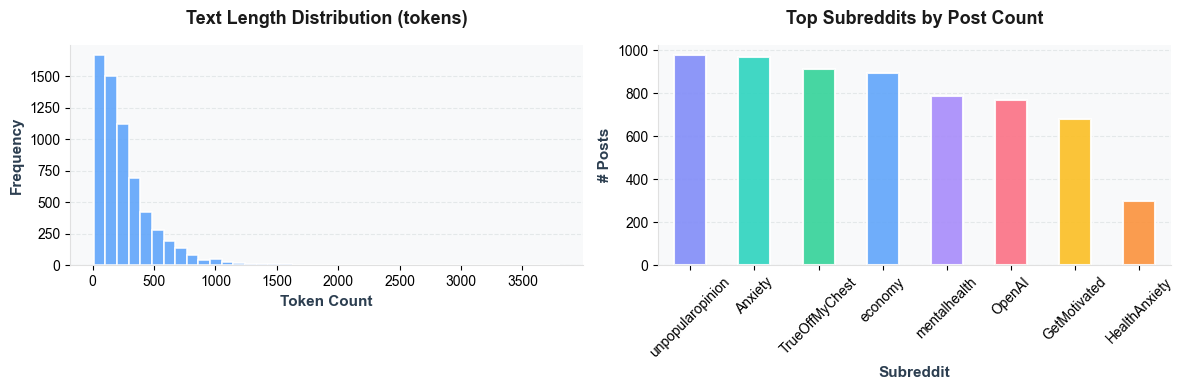

In [63]:
# Set style
sns.set_palette("husl")
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.facecolor'] = '#f8f9fa'
plt.rcParams['figure.facecolor'] = 'white'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# 1. Text Length Distribution
lens = df["text_all"].str.split().str.len().dropna()

ax1.hist(lens, bins=40, color='#60A5FA', edgecolor='white', linewidth=1.2, alpha=0.9)
ax1.set_title("Text Length Distribution (tokens)", 
              fontsize=13, fontweight='bold', color='#1a1a1a', pad=15)
ax1.set_xlabel("Token Count", fontsize=11, fontweight='bold', color='#2c3e50')
ax1.set_ylabel("Frequency", fontsize=11, fontweight='bold', color='#2c3e50')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_color('#e0e0e0')
ax1.spines['bottom'].set_color('#e0e0e0')
ax1.tick_params(colors='#000000', labelsize=10)
ax1.grid(axis='y', alpha=0.2, linestyle='--', linewidth=0.8, color='#95a5a6')
ax1.set_axisbelow(True)

# 2. Top Subreddits Bar Chart
top_subs = (df.groupby("subreddit")["post_id"].count()
              .sort_values(ascending=False).head(10))

colors = ['#818CF8', '#2DD4BF', '#34D399', '#60A5FA', '#A78BFA', 
          '#FB7185', '#FBBF24', '#FB923C', '#F43F5E', '#6EE7B7']

top_subs.plot(kind="bar", color=colors[:len(top_subs)], 
              edgecolor='white', linewidth=1.5, alpha=0.9, ax=ax2)
ax2.set_title("Top Subreddits by Post Count", 
              fontsize=13, fontweight='bold', color='#1a1a1a', pad=15)
ax2.set_xlabel("Subreddit", fontsize=11, fontweight='bold', color='#2c3e50')
ax2.set_ylabel("# Posts", fontsize=11, fontweight='bold', color='#2c3e50')
ax2.tick_params(axis='x', rotation=45, labelsize=10)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_color('#e0e0e0')
ax2.spines['bottom'].set_color('#e0e0e0')
ax2.tick_params(colors='#000000', labelsize=10)
ax2.grid(axis='y', alpha=0.2, linestyle='--', linewidth=0.8, color='#95a5a6')
ax2.set_axisbelow(True)

plt.tight_layout()
plt.savefig(ARTIFACTS / "data_overview.png", dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

---


## **8. Parameters & summary**
We persist the key decisions so downstream steps are reproducible.


In [64]:
# Save preprocessing parameters for reproducibility
params = {
    "keep_negations": True,
    "remove_urls_usernames": True,
    "comments_top_level_only": True,
    "topk_comments": int(k),
    "length_floor_tokens": int(length_floor),
    "date_range": {
        "min": str(df["created_dt"].min()) if "created_dt" in df else None,
        "max": str(df["created_dt"].max()) if "created_dt" in df else None,
    }
}

# Write parameters to JSON file
with open(DATA_PROC / "02_clean_merge_params.json", "w", encoding="utf-8") as f:
    json.dump(params, f, indent=2)
    
params

{'keep_negations': True,
 'remove_urls_usernames': True,
 'comments_top_level_only': True,
 'topk_comments': 5,
 'length_floor_tokens': 7,
 'date_range': {'min': '2024-09-27 09:58:44', 'max': '2025-09-18 17:34:21'}}

---


### **Next steps:**
- **Topics (NMF on TF‑IDF)**: read `../data/processed/reddit_anxiety_v1.parquet`, column `text_all`.
- **Clusters (k‑means on embeddings)**: same input; save `cluster_id` per post.
- **Labels (NRC)**: compute per‑emotion densities and an anxiety index from `text_all`.

[Next: Topic Modeling with NMF →](03_topic_modeling_byNMF.ipynb)